### Cognitive Modeling HW4 Problem 2

In [1]:
# Pip imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import stan

try:
    import arviz as az
except ImportError as err:
    print("Please, install arviz for easy visualization of Stan models.")

import nest_asyncio
nest_asyncio.apply()

import pandas as pd

print(stan.__version__)

/home/krupkaa/anaconda3/envs/cognitive/lib/python3.12/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


3.10.0


In [2]:
one_high_stan_code = """
data {
  int<lower=1> N_old; // Number of trials
  int<lower=1> N_new; // Number of trials
  array[2] int<lower=0, upper=N_old> freqs_old;
  array[2] int<lower=0, upper=N_new> freqs_new;
}

parameters {
  // Your code here
  real<lower=0, upper=1> d;
  real<lower=0, upper=1> g;
}

transformed parameters {
  simplex[2] theta_old;
  simplex[2] theta_new;
  
  theta_old[1] =  d + (1-d)*g;
  theta_old[2] = (1-d)*(1-g);

  theta_new[1] = g;
  theta_new[2] = (1-g);
}

model {
  // Assuming uniform priors
  target += beta_lpdf(d | 1, 1);
  target += beta_lpdf(g | 1, 1);

  // Multinomial likelihood
  target += multinomial_lpmf(freqs_old | theta_old);
  target += multinomial_lpmf(freqs_new | theta_new);
}

generated quantities{
  array[2] int pred_freqs_old;
  array[2] int pred_freqs_new;

  pred_freqs_old = multinomial_rng(theta_old, N_old);
  pred_freqs_new = multinomial_rng(theta_new, N_new);
}
"""

In [9]:
guessing_data = pd.read_csv("word_results.csv")

old_word_guessed_new_count = ((guessing_data["old?"] == "yes") & (guessing_data["response"] == "new")).sum()
old_word_guessed_old_count = ((guessing_data["old?"] == "yes") & (guessing_data["response"] == "old")).sum()

new_word_guessed_new_count = ((guessing_data["old?"] == "no") & (guessing_data["response"] == "new")).sum()
new_word_guessed_old_count = ((guessing_data["old?"] == "no") & (guessing_data["response"] == "old")).sum()

old_word_freq = (old_word_guessed_old_count, old_word_guessed_new_count)
new_word_freq = (new_word_guessed_old_count, new_word_guessed_new_count)

print ("Old Word Frequencies:", old_word_freq)
print ("New Word Frequencies:", new_word_freq)


Old Word Frequencies: (np.int64(8), np.int64(2))
New Word Frequencies: (np.int64(2), np.int64(8))


In [10]:
data_dict = { 
    'N_old': sum(old_word_freq),
    'N_new': sum(new_word_freq),
    'freqs_old': old_word_freq,
    'freqs_new': new_word_freq
}

one_high_model = stan.build(one_high_stan_code, data=data_dict)


Building...



Building: found in cache, done.

In [11]:
one_high_fit = one_high_model.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Sampling:   0%


Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 0.000346 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.46 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 9.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.93 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000112 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.12 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000123 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.23 seconds.
  Adjust your expectations accordingly!


In [12]:
# Get the summary of the fit
az.summary(one_high_fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d,0.652,0.175,0.326,0.948,0.002,0.002,5652.0,4088.0,1.0
g,0.270,0.126,0.053,0.502,0.002,0.001,5254.0,4985.0,1.0
theta_old[0],0.754,0.116,0.541,0.952,0.001,0.001,7633.0,6989.0,1.0
theta_old[1],0.246,0.116,0.048,0.459,0.001,0.001,7633.0,6989.0,1.0
theta_new[0],0.270,0.126,0.053,0.502,0.002,0.001,5254.0,4985.0,1.0
theta_new[1],0.730,0.126,0.498,0.947,0.002,0.001,5254.0,4985.0,1.0
pred_freqs_old[0],7.549,1.758,5.000,10.000,0.018,0.014,9363.0,9343.0,1.0
pred_freqs_old[1],2.451,1.758,0.000,5.000,0.018,0.014,9363.0,9024.0,1.0
pred_freqs_new[0],2.689,1.829,0.000,6.000,0.022,0.014,7037.0,7760.0,1.0
pred_freqs_new[1],7.311,1.829,4.000,10.000,0.022,0.014,7037.0,8913.0,1.0


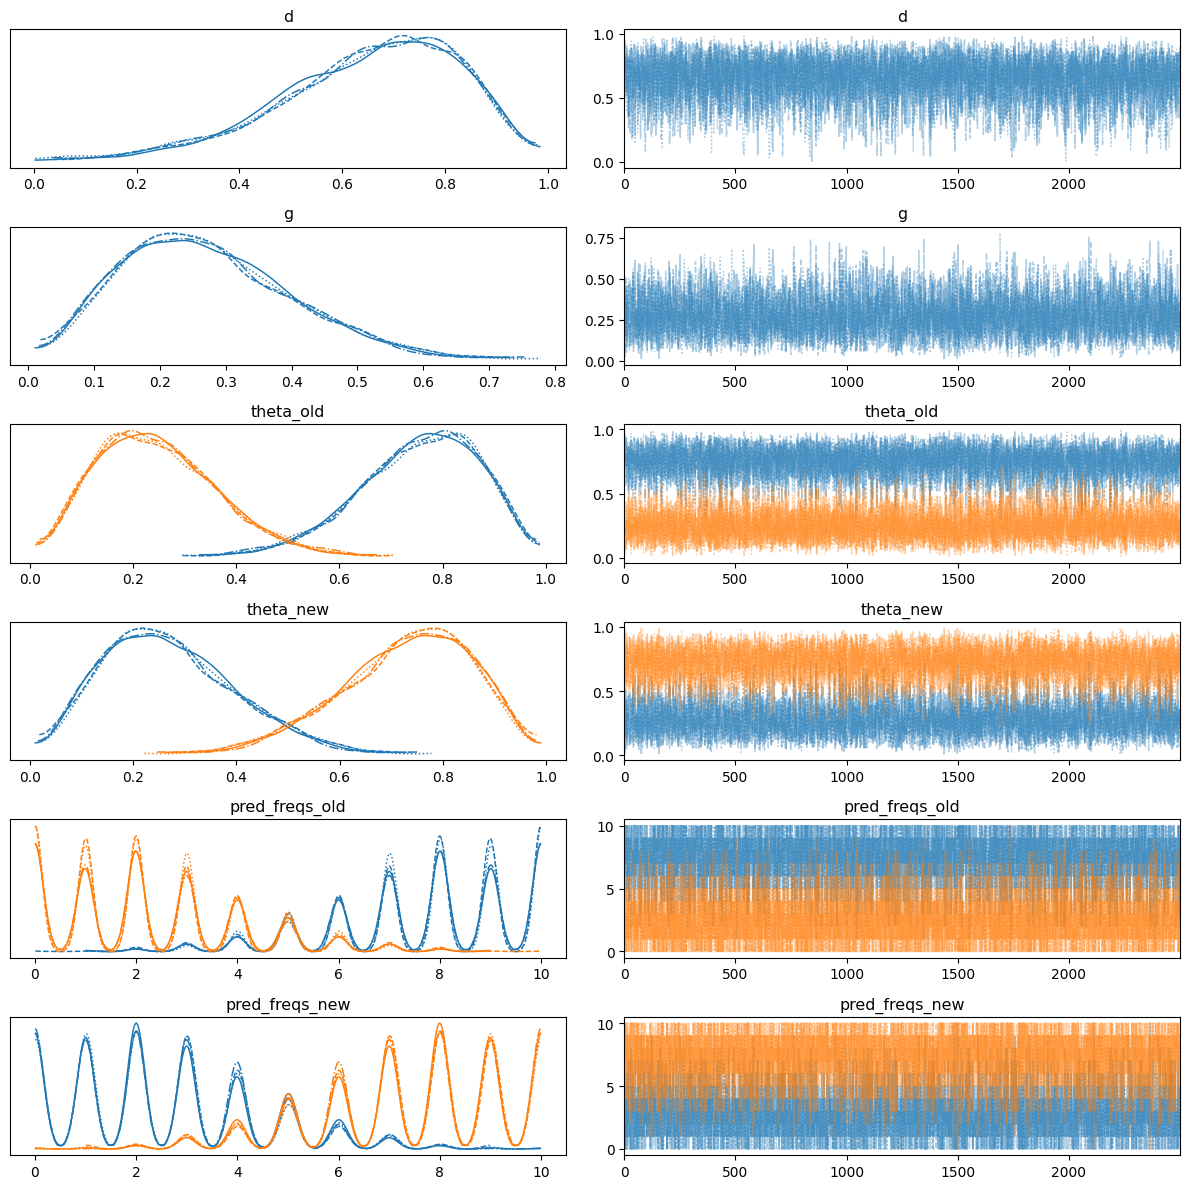

In [13]:
axarr = az.plot_trace(one_high_fit)
plt.tight_layout()

In [14]:
two_high_stan_code = """
data {
  int<lower=1> N_old; // Number of trials
  int<lower=1> N_new; // Number of trials
  array[2] int<lower=0, upper=N_old> freqs_old;
  array[2] int<lower=0, upper=N_new> freqs_new;
}

parameters {
  // Your code here
  real<lower=0, upper=1> d;
  real<lower=0, upper=1> g;
}

transformed parameters {
  simplex[2] theta_old;
  simplex[2] theta_new;
  
  theta_old[1] =  d + (1-d)*g;
  theta_old[2] = (1-d)*(1-g);

  theta_new[1] = (1-d)*g;
  theta_new[2] = d+(1-d)*(1-g);
}

model {
  // Assuming uniform priors
  target += beta_lpdf(d | 1, 1);
  target += beta_lpdf(g | 1, 1);

  // Multinomial likelihood
  target += multinomial_lpmf(freqs_old | theta_old);
  target += multinomial_lpmf(freqs_new | theta_new);
}

generated quantities{
  array[2] int pred_freqs_old;
  array[2] int pred_freqs_new;

  pred_freqs_old = multinomial_rng(theta_old, N_old);
  pred_freqs_new = multinomial_rng(theta_new, N_new);
}
"""

In [15]:
two_high_model = stan.build(two_high_stan_code, data=data_dict)


Building...



Building: found in cache, done.

In [16]:
two_high_fit = two_high_model.sample(num_chains=4, num_samples=2500, num_warmup=1000)

Sampling:   0%
Sampling:  25% (3500/14000)
Sampling:  50% (7000/14000)
Sampling:  75% (10500/14000)
Sampling: 100% (14000/14000)
Sampling: 100% (14000/14000), done.
Messages received during sampling:
  Gradient evaluation took 0.000825 seconds
  1000 transitions using 10 leapfrog steps per transition would take 8.25 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000252 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.52 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000303 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000369 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.69 seconds.
  Adjust your expectations accordingly!


In [17]:
# Get the summary of the fit
az.summary(two_high_fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d,0.568,0.160,0.256,0.846,0.002,0.002,6571.0,4651.0,1.0
g,0.501,0.177,0.184,0.834,0.002,0.002,6436.0,5551.0,1.0
theta_old[0],0.784,0.111,0.580,0.969,0.001,0.001,6667.0,6387.0,1.0
theta_old[1],0.216,0.111,0.031,0.420,0.001,0.001,6667.0,6387.0,1.0
theta_new[0],0.217,0.112,0.030,0.423,0.001,0.001,6349.0,5883.0,1.0
theta_new[1],0.783,0.112,0.577,0.970,0.001,0.001,6349.0,5883.0,1.0
pred_freqs_old[0],7.834,1.677,5.000,10.000,0.018,0.014,8325.0,8046.0,1.0
pred_freqs_old[1],2.166,1.677,0.000,5.000,0.018,0.014,8325.0,8873.0,1.0
pred_freqs_new[0],2.166,1.682,0.000,5.000,0.019,0.014,8005.0,8523.0,1.0
pred_freqs_new[1],7.834,1.682,5.000,10.000,0.019,0.014,8005.0,8564.0,1.0


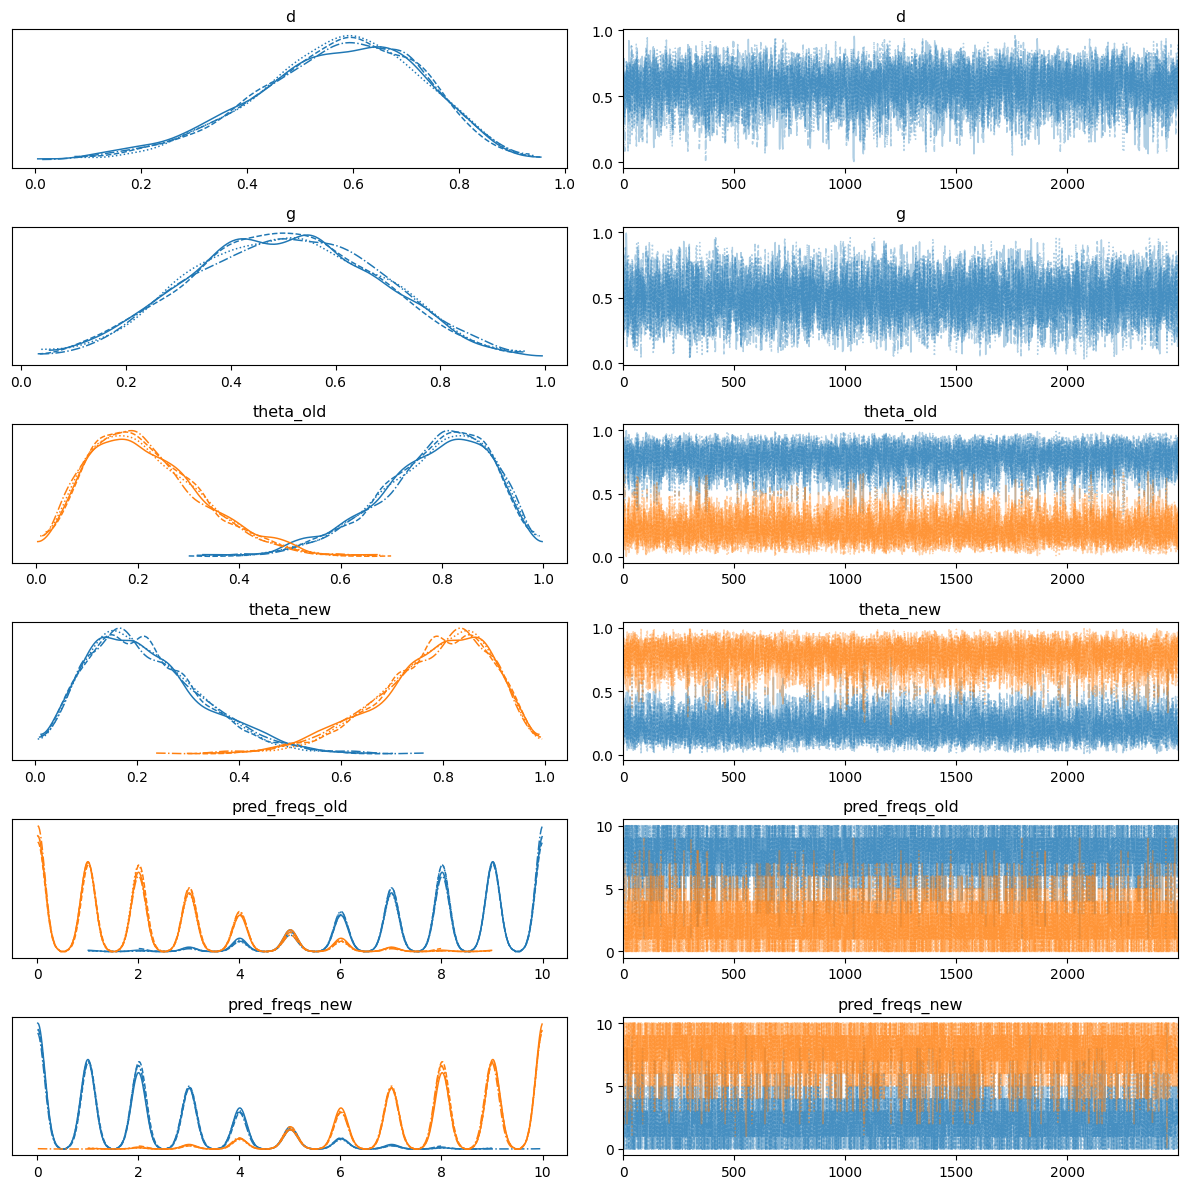

In [18]:
axarr = az.plot_trace(two_high_fit)
plt.tight_layout()

Text(0.5, 0, 'Value')

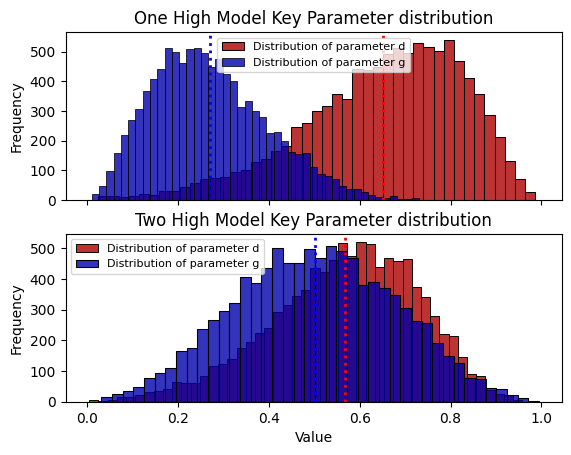

In [48]:
# Plot the results of each key parameter

one_high_model_frame = one_high_fit.to_frame()
two_high_model_frame = two_high_fit.to_frame()


f, ax = plt.subplots(2, 1, sharex=True)

sns.histplot(
        one_high_model_frame, x='d', ax=ax[0], color='#AA0000', alpha=0.8, lw=2, label=f'Distribution of parameter d')
sns.histplot(
        one_high_model_frame, x='g', ax=ax[0], color='#0000AA', alpha=0.8, lw=2, label=f'Distribution of parameter g')

ax[0].axvline(np.mean(one_high_model_frame['d']), color='red', linestyle='dotted', lw=2)
ax[0].axvline(np.mean(one_high_model_frame['g']), color='blue', linestyle='dotted', lw=2)

sns.histplot(
        two_high_model_frame, x='d', ax=ax[1], color='#AA0000', alpha=0.8, lw=2, label=f'Distribution of parameter d')
sns.histplot(
        two_high_model_frame, x='g', ax=ax[1], color='#0000AA', alpha=0.8, lw=2, label=f'Distribution of parameter g')

ax[1].axvline(np.mean(two_high_model_frame['d']), color='red', linestyle='dotted', lw=2)
ax[1].axvline(np.mean(two_high_model_frame['g']), color='blue', linestyle='dotted', lw=2)


# Labels and embelishments
ax[0].set_title('One High Model Key Parameter distribution')
ax[0].legend(fontsize=8)
ax[0].set_ylabel('Frequency')

ax[1].set_title('Two High Model Key Parameter distribution')
ax[1].legend(fontsize=8)
ax[1].set_ylabel('Frequency')

ax[1].set_xlabel('Value')


# Predicted Frequency Distributions

Text(0.5, 0, 'Number of Words')

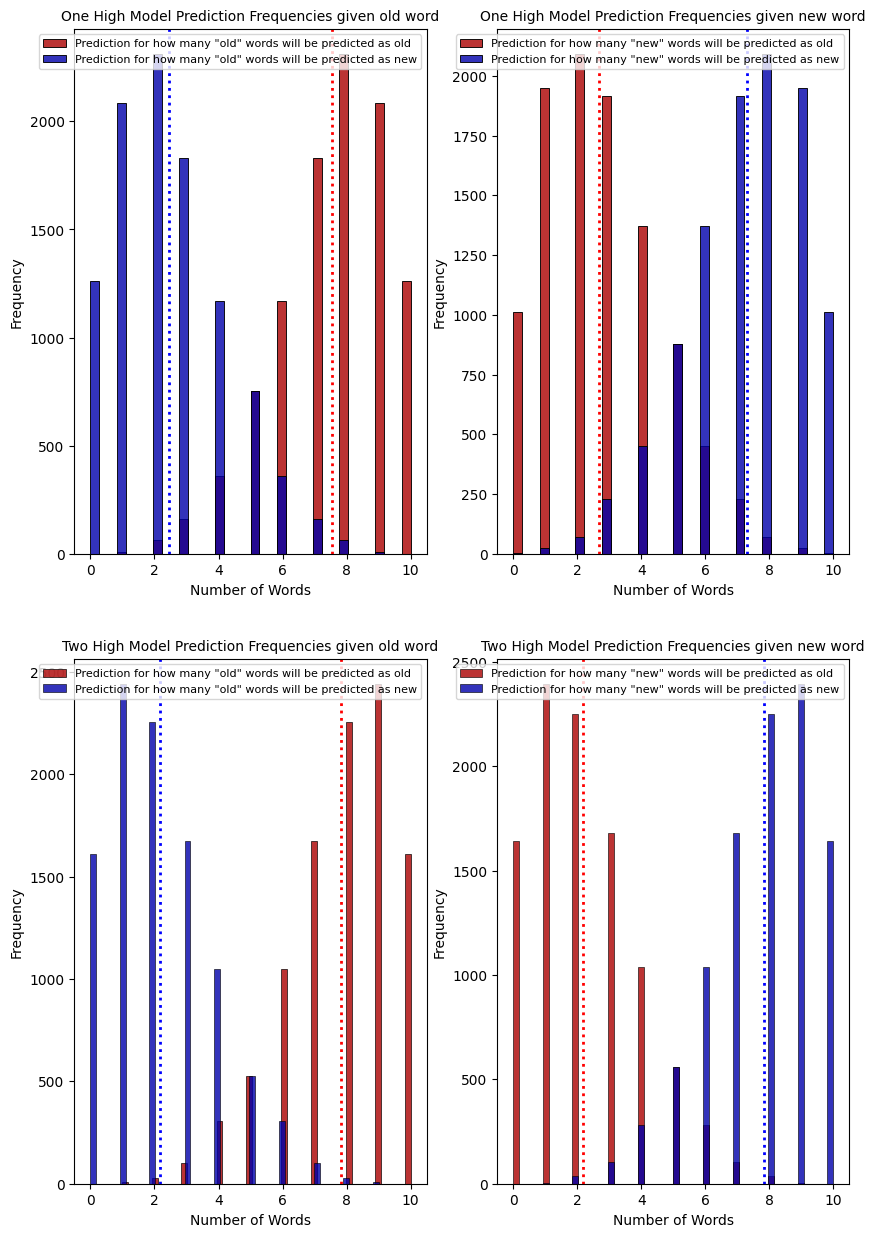

In [62]:
# Plot the results of each key parameter



f, ax = plt.subplots(2, 2, figsize=(10, 15))


sns.histplot(
        one_high_model_frame, x='pred_freqs_old.1', ax=ax[0][0], color='#AA0000', alpha=0.8, lw=2, label=f'Prediction for how many "old" words will be predicted as old')

sns.histplot(
        one_high_model_frame, x='pred_freqs_old.2', ax=ax[0][0], color='#0000AA', alpha=0.8, lw=2, label=f'Prediction for how many "old" words will be predicted as new')

ax[0][0].axvline(np.mean(one_high_model_frame['pred_freqs_old.1']), color='red', linestyle='dotted', lw=2)
ax[0][0].axvline(np.mean(one_high_model_frame['pred_freqs_old.2']), color='blue', linestyle='dotted', lw=2)

sns.histplot(
        one_high_model_frame, x='pred_freqs_new.1', ax=ax[0][1], color='#AA0000', alpha=0.8, lw=2, label=f'Prediction for how many "new" words will be predicted as old')
sns.histplot(
        one_high_model_frame, x='pred_freqs_new.2', ax=ax[0][1], color='#0000AA', alpha=0.8, lw=2, label=f'Prediction for how many "new" words will be predicted as new')

ax[0][1].axvline(np.mean(one_high_model_frame['pred_freqs_new.1']), color='red', linestyle='dotted', lw=2)
ax[0][1].axvline(np.mean(one_high_model_frame['pred_freqs_new.2']), color='blue', linestyle='dotted', lw=2)

sns.histplot(
        two_high_model_frame, x='pred_freqs_old.1', ax=ax[1][0], color='#AA0000', alpha=0.8, lw=2, label=f'Prediction for how many "old" words will be predicted as old')

sns.histplot(
        two_high_model_frame, x='pred_freqs_old.2', ax=ax[1][0], color='#0000AA', alpha=0.8, lw=2, label=f'Prediction for how many "old" words will be predicted as new')

ax[1][0].axvline(np.mean(two_high_model_frame['pred_freqs_old.1']), color='red', linestyle='dotted', lw=2)
ax[1][0].axvline(np.mean(two_high_model_frame['pred_freqs_old.2']), color='blue', linestyle='dotted', lw=2)

sns.histplot(
        two_high_model_frame, x='pred_freqs_new.1', ax=ax[1][1], color='#AA0000', alpha=0.8, lw=2, label=f'Prediction for how many "new" words will be predicted as old')
sns.histplot(
        two_high_model_frame, x='pred_freqs_new.2', ax=ax[1][1], color='#0000AA', alpha=0.8, lw=2, label=f'Prediction for how many "new" words will be predicted as new')

ax[1][1].axvline(np.mean(two_high_model_frame['pred_freqs_new.1']), color='red', linestyle='dotted', lw=2)
ax[1][1].axvline(np.mean(two_high_model_frame['pred_freqs_new.2']), color='blue', linestyle='dotted', lw=2)


# Labels and embelishments
ax[0][0].set_title('One High Model Prediction Frequencies given old word', fontsize=10)
ax[0][0].legend(fontsize=8)
ax[0][0].set_ylabel('Frequency')
ax[0][0].set_xlabel('Number of Words')

ax[0][1].set_title('One High Model Prediction Frequencies given new word', fontsize=10)
ax[0][1].legend(fontsize=8)
ax[0][1].set_ylabel('Frequency')
ax[0][1].set_xlabel('Number of Words')

ax[1][0].set_title('Two High Model Prediction Frequencies given old word', fontsize=10)
ax[1][0].legend(fontsize=8)
ax[1][0].set_ylabel('Frequency')
ax[1][0].set_xlabel('Number of Words')

ax[1][1].set_title('Two High Model Prediction Frequencies given new word', fontsize=10)
ax[1][1].legend(fontsize=8)
ax[1][1].set_ylabel('Frequency')
ax[1][1].set_xlabel('Number of Words')